In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
%cd '/content/gdrive/MyDrive/DeepLearning_GL/Projects/capstone_project/Capstone_CV_Project/final_submission/classification_part/'

In [ ]:
import tensorflow
tensorflow.__version__

In [ ]:
!pip install pydicom

In [ ]:
import pandas as pd
import numpy as np
import os
from pathlib import Path
import pydicom 
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Tuple
import cv2
from cv2 import imread,resize,INTER_AREA,flip
import random
random.seed(10)

import pydicom
from pydicom.dataset import FileDataset, FileMetaDataset
from pydicom.uid import UID

import tensorflow as tf
from sklearn.model_selection import train_test_split
# example of loading the resnet50 model
# %%tensorflow_version 2.x
import tensorflow
import random
import numpy as np
from tensorflow.keras.applications.resnet_v2 import ResNet50V2


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten
from tensorflow.keras import regularizers, optimizers
# import keras_tuner as kt
import statistics
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, array_to_img
from tensorflow.keras.callbacks import ReduceLROnPlateau 

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve,auc
from sklearn.metrics import f1_score, make_scorer
from sklearn.metrics import confusion_matrix

In [ ]:
process_storage_folder_path:str = os.path.join(os.getcwd(),'data_set') 
saved_file_name_coordinates:str = os.path.join(process_storage_folder_path, "coordinates_org.pkl")
coordinates_info:pd.DataFrame = pd.read_pickle(saved_file_name_coordinates)
coordinates_info.head(2)

,Patient_ids,Class,Encoded_class,Gender,Age,View_position,Modality,coordinates,No_rows,No_columns
0,f74e692e-1ccd-4f5e-bc19-482325025a41,Normal,0,F,62,AP,CR,"[nan, nan, nan, nan]",1024,1024
1,f7909c0c-c9f0-4c93-be7f-113926850ac3,No Lung Opacity / Not Normal,0,F,81,AP,CR,"[nan, nan, nan, nan]",1024,1024


In [ ]:
x:pd.Series = coordinates_info['Patient_ids']
y:pd.Series = coordinates_info['Encoded_class']
x_train, x_val, y_train, y_val =   X_train, X_test, Y_train, Y_test = train_test_split(
      x, y,
      test_size=0.25,
      random_state=27,
      shuffle=True,
      stratify = y
  )

x_val, x_test, y_val, y_test =   X_train, X_test, Y_train, Y_test = train_test_split(
      x_val, y_val,
      test_size=0.25,
      random_state=27,
      shuffle=True,
      stratify = y_val
  )
print(f'The shape of tain sample {len(x_train)}')
print(f'The shape of tain sample {len(x_val)}')
print(f'The shape of tain sample {len(x_test)}')

The shape of tain sample 20013
The shape of tain sample 5003
The shape of tain sample 1668


In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip(mode="horizontal", seed=22),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1,0.2),
    layers.RandomBrightness(factor=[0.0,0.2]),
])

def basic_pre_processing(pixels_values):
    # pixels_values = cv2.cvtColor(pixels_values, cv2.COLOR_GRAY2RGB)
    #creating extra dimension
    pixels_values:np.array = np.stack((pixels_values,) * 3, -1)
    #resizing the image
    pixels_values:np.array = cv2.resize(pixels_values, (224,224),interpolation = cv2.INTER_NEAREST).astype('float16')
    #scaling the image.
    pixels_values:np.array = pixels_values/pixels_values.max()
    return pixels_values
    
def read_dicom(file_name):
    path_image:str = os.path.join(train_folder_path,file_name+'.dcm')
    dicom_obj:pydicom.dataset.FileDataset = pydicom.read_file(path_image)
    pixels_values:np.array = dicom_obj.pixel_array
    return pixels_values
    
def get_trainImage_fromDicom():
    #getting the difference value of frequency between minor and major class. 
    class_distribution_target:pd.DataFrame = y_train.value_counts().reset_index().rename(columns = {'index':'class',
                                                                                 'Encoded_class':'frequency'}, inplace = False)
    difference_in_frequency = class_distribution_target.iloc[:,1][0] - class_distribution_target.iloc[:,1][1]
    difference_in_frequency
    count = 0
    for file_name,label in zip(x_train,y_train):
        #if the class label is pneumonia
        if label == 1 and count <= difference_in_frequency:
            #upsampling
            number_samples = [10,20,40,3,5,7,15,1,25,30,50,0]
            no_samples_generate = random.choice(number_samples)
#             print(no_samples_generate)
            if no_samples_generate == 0:
                count+=1
                #reading the image.
                pixels_values = read_dicom(file_name)
                final_pixels_values = basic_pre_processing(pixels_values)
                yield final_pixels_values,label
            elif no_samples_generate == 1:
                #reading the image.
                pixels_values = read_dicom(file_name)
#                 print("1")
#                 print(pixels_values.shape)
                processed_image = basic_pre_processing(pixels_values)
                final_pixels_values = data_augmentation(processed_image).numpy()
                count+=1
                yield final_pixels_values,label
            else:
                for sample_number in range(0,no_samples_generate):
                    #reading the image.
                    pixels_values = read_dicom(file_name)
                    processed_image = basic_pre_processing(pixels_values)
#                     print("2")
#                     print(processed_image.shape)
                    final_pixels_values = data_augmentation(processed_image).numpy()
                    count+=1
                    yield final_pixels_values,label
        else:
            #reading the image.
            pixels_values = read_dicom(file_name)
            final_pixels_values = basic_pre_processing(pixels_values)
            yield final_pixels_values,label
    
def get_valImage_fromDicom():
    for file_name,label in zip(x_val,y_val):
        #reading the image.
        pixels_values = read_dicom(file_name)
        pixels_values = basic_pre_processing(pixels_values)
        yield pixels_values,label
        
def get_testImage_fromDicom():
    for file_name,label in zip(x_test,y_test):
        #reading the image.
        pixels_values = read_dicom(file_name)
        pixels_values = basic_pre_processing(pixels_values)
        yield pixels_values,label

In [ ]:
train_folder_name:str = 'stage_2_train_images'
train_folder_path:str = os.path.join(process_storage_folder_path,
                                     train_folder_name)

#hyper parameters
batch_size:int = 16
learning_rate:float = 1e-3
decay_rate:float = 1e-6
epochs:int=100

train_set_iterator = tf.data.Dataset.from_generator(get_trainImage_fromDicom,
                                                    output_signature=(
                                                      tf.TensorSpec(shape=(224,224,3), dtype=tf.float16),
                                                      tf.TensorSpec(shape=(), dtype=tf.int32)
                                                      )
                                                    )
val_set_iterator = tf.data.Dataset.from_generator(get_valImage_fromDicom,
                                                   output_signature=(
                                                      tf.TensorSpec(shape=(224,224,3), dtype=tf.float16),
                                                      tf.TensorSpec(shape=(), dtype=tf.int32)
                                                      )
                                                    )
test_set_iterator = tf.data.Dataset.from_generator(get_testImage_fromDicom,
                                                   output_signature=(
                                                      tf.TensorSpec(shape=(224,224,3), dtype=tf.float16),
                                                      tf.TensorSpec(shape=(), dtype=tf.int32)
                                                      )
                                                  )

print("Training iterator.........")
train_set_iterator = train_set_iterator.batch(batch_size=batch_size)
for batch in train_set_iterator:
  arr,la = batch
  print(arr.shape)
  break

print("Validation iterator.........")
val_set_iterator = val_set_iterator.batch(batch_size=batch_size) 
for batch in val_set_iterator:
  arr,la = batch
  print(arr.shape)
  break

print("Test iterator.........")
test_set_iterator = test_set_iterator.batch(batch_size=batch_size) 
for batch in test_set_iterator:
  arr,la = batch
  print(arr.shape)
  break

Training iterator.........
(16, 224, 224, 3)
Validation iterator.........
(16, 224, 224, 3)
Test iterator.........
(16, 224, 224, 3)


### Defining model

In [ ]:
# load model
resnet50v2_base_model = ResNet50V2(include_top=False, 
                   weights='imagenet',
                   input_shape=(224,224,3))
# summarize the model
resnet50v2_base_model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                         

                                                                                                  
 conv2_block3_preact_relu (Acti  (None, 56, 56, 256)  0          ['conv2_block3_preact_bn[0][0]'] 
 vation)                                                                                          
                                                                                                  
 conv2_block3_1_conv (Conv2D)   (None, 56, 56, 64)   16384       ['conv2_block3_preact_relu[0][0]'
                                                                 ]                                
                                                                                                  
 conv2_block3_1_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_blo

 conv3_block2_2_conv (Conv2D)   (None, 28, 28, 128)  147456      ['conv3_block2_2_pad[0][0]']     
                                                                                                  
 conv3_block2_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_3_conv (Conv2D)   (None, 28, 28, 512)  66048       ['conv3_block2_2_relu[0][0]']    
                                                                                                  
 conv3_blo

 conv4_block1_1_conv (Conv2D)   (None, 14, 14, 256)  131072      ['conv4_block1_preact_relu[0][0]'
                                                                 ]                                
                                                                                                  
 conv4_block1_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block1_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block1_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block1_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block1_2_pad (ZeroPaddin  (None, 16, 16, 256)  0          ['conv4_block1_1_relu[0][0]']    
 g2D)     

                                                                                                  
 conv4_block3_2_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block3_3_conv (Conv2D)   (None, 14, 14, 1024  263168      ['conv4_block3_2_relu[0][0]']    
                                )                                                                 
                                                                                                  
 conv4_block3_out (Add)         (None, 14, 14, 1024  0           ['conv4_block2_out[0][0]',       
                                )                                 'conv4_block3_3_conv[0][0]']    
                                                                                                  
 conv4_blo

 conv4_block6_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block6_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block6_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block6_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block6_2_pad (ZeroPaddin  (None, 16, 16, 256)  0          ['conv4_block6_1_relu[0][0]']    
 g2D)                                                                                             
                                                                                                  
 conv4_block6_2_conv (Conv2D)   (None, 7, 7, 256)    589824      ['conv4_block6_2_pad[0][0]']     
          

                                                                                                  
 conv5_block2_3_conv (Conv2D)   (None, 7, 7, 2048)   1050624     ['conv5_block2_2_relu[0][0]']    
                                                                                                  
 conv5_block2_out (Add)         (None, 7, 7, 2048)   0           ['conv5_block1_out[0][0]',       
                                                                  'conv5_block2_3_conv[0][0]']    
                                                                                                  
 conv5_block3_preact_bn (BatchN  (None, 7, 7, 2048)  8192        ['conv5_block2_out[0][0]']       
 ormalization)                                                                                    
                                                                                                  
 conv5_block3_preact_relu (Acti  (None, 7, 7, 2048)  0           ['conv5_block3_preact_bn[0][0]'] 
 vation)  

In [ ]:
tf.random.set_seed(21)
number_of_layers = len(resnet50v2_base_model.layers)
number_last_layers_to_be_trainable = 40
count = 0

for layer in resnet50v2_base_model.layers:
  if count < (number_of_layers-number_last_layers_to_be_trainable):
    layer.trainable = False
    count+=1
  else:
    count+=1

In [ ]:
prediction_layer = layers.Dense(1,activation = 'sigmoid')
flatten_layer = layers.Flatten()
inputs = tensorflow.keras.Input(shape=(224, 224, 3))
x = tensorflow.keras.applications.resnet_v2.preprocess_input(inputs)
x = resnet50v2_base_model(x)
x = layers.Dropout(0.2)(x)
x = flatten_layer(x)
outputs = prediction_layer(x)
resnetv2_50_finetuned_model = tensorflow.keras.Model(inputs, outputs)

In [ ]:
resnetv2_50_finetuned_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 dropout (Dropout)           (None, 7, 7, 2048)        0         
                                                                 
 flatten (Flatten)           (None, 100352)            0     

In [ ]:
save_model_path = os.path.join(os.getcwd(),"training_weights",
                              "resnet50v2",
                               "best_resnet50v2_model.h5")
#hyper parameters
learning_rate = 1e-2
batch_size = 16
epochs = 1000

early_stopping = EarlyStopping(monitor='loss',mode = "min",patience=10)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=4, min_lr=1e-9, verbose=1)
model_checkpoint=tensorflow.keras.callbacks.ModelCheckpoint(save_model_path, 
                                                    save_best_only=True,
                                                    save_weights_only=True, 
                                                    monitor='val_accuracy', 
                                                    mode='max', 
                                                    verbose=1)
history_logges_path= os.path.join(os.getcwd(),"training_weights",
                              "resnet50v2",
                               "loggs.csv")
history_logger=tf.keras.callbacks.CSVLogger(history_logges_path, separator=",", append=True)

adam = tensorflow.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
resnetv2_50_finetuned_model.compile(optimizer=adam,
              loss='binary_crossentropy',
              metrics=['accuracy',tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [ ]:
random.seed(2)
np.random.seed(2)
tf.random.set_seed(2)
history = resnetv2_50_finetuned_model.fit(
  train_set_iterator,
  validation_data=test_set_iterator,
  batch_size=batch_size,
  epochs=epochs,
  callbacks=[early_stopping,model_checkpoint,reduce_lr,history_logger],
  workers = 2*batch_size,
  verbose=1,
  shuffle=True,
  use_multiprocessing=True
)

Epoch 1/1000
   1899/Unknown - 10084s 5s/step - loss: 8.4036 - accuracy: 0.7773 - precision: 0.8126 - recall: 0.7083
Epoch 1: val_accuracy improved from -inf to 0.77458, saving model to C:\Users\uUUUUvvvv\Desktop\projects\capstone_project\final_pre_processed_data\classifier_trained_weights\resnet_50v2best_resnet50v2_model.h5
1899/1899 [==============================] - 10361s 5s/step - loss: 8.4036 - accuracy: 0.7773 - precision: 0.8126 - recall: 0.7083 - val_loss: 7.6083 - val_accuracy: 0.7746 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 0.0100
Epoch 2/1000
1899/1899 [==============================] - ETA: 0s - loss: 1.6671 - accuracy: 0.8334 - precision: 0.9099 - recall: 0.7328
Epoch 2: val_accuracy did not improve from 0.77458
1899/1899 [==============================] - 4939s 3s/step - loss: 1.6671 - accuracy: 0.8334 - precision: 0.9099 - recall: 0.7328 - val_loss: 0.4853 - val_accuracy: 0.7746 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 0.0100
Epoch 3/

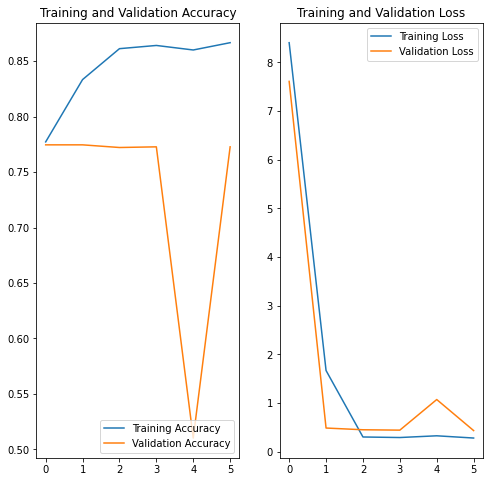

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range[:len(acc)], acc, label='Training Accuracy')
plt.plot(epochs_range[:len(acc)], val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range[:len(acc)], loss, label='Training Loss')
plt.plot(epochs_range[:len(acc)], val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
resnetv2_50_finetuned_model.save(os.path.join(os.getcwd(),"training_weights",
                              "resnet50v2",
                               "best_resnet50v2_model_complete.h5"))